In [49]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download(['punkt', 'wordnet','stopwords'])
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from scipy.stats import norm

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, make_scorer,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zaplu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zaplu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zaplu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Airbnb Prices in Amsterdam: Data Analysis

# 1. Business Understanding

The aim of this project is to analyze prices of Airbnb listings in Amsterdam, focusing primarily on comparing average prices (per person per night) in different city districts, and trying to identify value-adding features that might be interesting to the visitors of Amsterdam.

The analysis provides a general overview of the Airbnb market in Amsterdam, and can also serve as a guide to all future visitors, as it answers questions such as where to stay if travelling on budget, or how large is the premium for more central apartments. By using text processing techniques I also analyze guest reviews to find out which parts of the city the visitors think are well-located. For each Amsterdam neighborhood I calculate the percentage of reviews that include positive comments about the location, and then analyze if such statistics are in line with the price differences observed. Through this analysis I also aim to identify districts that are under or over priced given their location.

Location is one of the main factors impacting Airbnb prices, but on the level of individual listings there are obviously several other differentiating aspects. In the last part of my analysis I aim to identify features that add value to Airbnb apartments, by analyzing the information contained in listings’ textual descriptions. I answer questions such as how much extra on average one needs to pay if an apartment is advertised as luxurious, spacious, cosy, modern, etc., or how large is the premium for having a garden or a terrace, or very specific to Amsterdam, how much more expensive it is to stay just next to a canal, or on it, in a houseboat.

In summary, my analysis consists of 3 parts:
- compare average price per person per night between different neighborhoods in Amsterdam;
- analyze whether the average prices in Amsterdam neigborhoods are correlated with the ratio of positive location reviews;
- find out how much extra one needs to pay on average for an apartment advertised (in the Airbnb title) as luxurious, spacious, modern, having a garden, being close to a canal, being a houseboat etc.

# 2. Data Understanding
To perform the analysis I import two Airbnb datasets that are publically available on the following website http://insideairbnb.com/get-the-data.html. The `listings` dataframe includes detailed data of all listings in Amsterdam, and the `review` dataframe collects the guest reviews. According to the website, both datasets have been compiled on July 8, 2019.

In [50]:
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

In [51]:
listings.shape

(20337, 106)

In [52]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20190708161114,2019-07-09,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.09
1,20168,https://www.airbnb.com/rooms/20168,20190708161114,2019-07-09,Studio with private bathroom in the centre 1,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,2.45
2,25428,https://www.airbnb.com/rooms/25428,20190708161114,2019-07-09,Lovely apt in City Centre (w.lift) near Jordaan,NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.17
3,27886,https://www.airbnb.com/rooms/27886,20190708161114,2019-07-09,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,For a romantic couple: A beautifully restored ...,Stylish and romantic houseboat on fantastic hi...,none,"Central, quiet, safe, clean and beautiful.",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.14
4,28871,https://www.airbnb.com/rooms/28871,20190708161114,2019-07-09,Comfortable double room,NaN,In a monumental house right in the center of A...,In a monumental house right in the center of A...,none,NaN,...,f,f,moderate,f,f,3,0,3,0,2.56


In [53]:
listings.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

In [54]:
#Columns with missing values
listings.isna().sum().sort_values(ascending=False) 

neighbourhood_group_cleansed                    20337
host_acceptance_rate                            20337
medium_url                                      20337
thumbnail_url                                   20337
xl_picture_url                                  20337
license                                         20323
square_feet                                     19948
monthly_price                                   18916
weekly_price                                    17714
notes                                           11192
host_response_time                               8578
host_response_rate                               8578
host_about                                       8447
access                                           8149
interaction                                      7850
house_rules                                      7656
neighborhood_overview                            6486
transit                                          6214
security_deposit            

In [55]:
#Distribution of listings type
listings.groupby('room_type').count()['id']

room_type
Entire home/apt    16148
Private room        4118
Shared room           71
Name: id, dtype: int64

In [56]:
#The number of listings in each neighbourhood
listings.groupby('neighbourhood_cleansed').count()['id'].sort_values(ascending = False)

neighbourhood_cleansed
De Baarsjes - Oud-West                    3468
De Pijp - Rivierenbuurt                   2503
Centrum-West                              2317
Centrum-Oost                              1778
Westerpark                                1506
Zuid                                      1425
Oud-Oost                                  1349
Bos en Lommer                             1162
Oostelijk Havengebied - Indische Buurt     966
Oud-Noord                                  613
Watergraafsmeer                            579
IJburg - Zeeburgereiland                   491
Slotervaart                                397
Noord-West                                 363
Noord-Oost                                 279
Buitenveldert - Zuidas                     263
Geuzenveld - Slotermeer                    220
De Aker - Nieuw Sloten                     150
Gaasperdam - Driemond                      142
Osdorp                                     141
Bijlmer-Centrum                      

In [57]:
#The distribution of the apartment size in the listings dataset, measured by the number of people that can be accommodated
listings.groupby(['accommodates'])['id'].count()

accommodates
1       468
2     10978
3      1620
4      6271
5       394
6       411
7        48
8        81
9         8
10       12
11        3
12       11
14        3
16       28
17        1
Name: id, dtype: int64

In [58]:
reviews.shape

(472846, 6)

In [59]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [60]:
#Identify missing values in the reviews dataset
reviews.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         195
dtype: int64

# 3. Data preparation

### a) Obtain prices per person per night
Airbnb rent prices are listed per night but not always per person. Each Airbnb host can specify how many guests are included in the listed price, and charge extra for each additional guest that can be accommodated. This means that there are large differences in prices due to discrepancies between number of guests included, making it difficult to directly compare the listings. Rather than analyzing the size-driven price differences, I focus on what is more interesting for an average Airbnb user when searching for a place to stay — price **per person** (per night). For a given apartment I obtain the normalized price by first calculating the total per night costs corresponding to apartment’s capacity, and then dividing by apartment’s capacity.

In [61]:
#The columns needed for obtaining prices per person per night
listings[['price', 'accommodates', 'guests_included', 'extra_people']].head()

,price,accommodates,guests_included,extra_people
0,$59.00,2,1,$20.00
1,$80.00,2,2,$0.00
2,$125.00,3,2,$10.00
3,$150.00,2,1,$0.00
4,$75.00,2,1,$0.00


In [62]:
#The columns needed for calculation do not have any missing values
listings[['price', 'accommodates', 'guests_included', 'extra_people']].isna().sum()

price              0
accommodates       0
guests_included    0
extra_people       0
dtype: int64

In [63]:
#Convert the prices to numerical variable
price_clean = listings['price'].str.replace("$","").str.replace(',','').astype(float)

In [64]:
#Obtain the number of people that can be accommodated but are not included in the price
extra_space = (listings['accommodates'] - listings['guests_included'])
#Due to inconsistencies in the imported data this number is negative in some rare cases. We floor it to 0.
extra_space = extra_space.apply(lambda x: 0 if x<0 else x)
#Calculate the extra costs
extra_price = extra_space*listings['extra_people'].str.replace("$","").str.replace(',','').astype(float)

In [65]:
#Obtain the price at full capacity and calculate price per person per night
listings['price_pp'] = (price_clean + extra_price) / listings['accommodates']

In [66]:
listings['price_pp'].describe()

count    20337.000000
mean        60.768798
std         54.787343
min          0.000000
25%         42.500000
50%         54.166667
75%         70.000000
max       3815.000000
Name: price_pp, dtype: float64

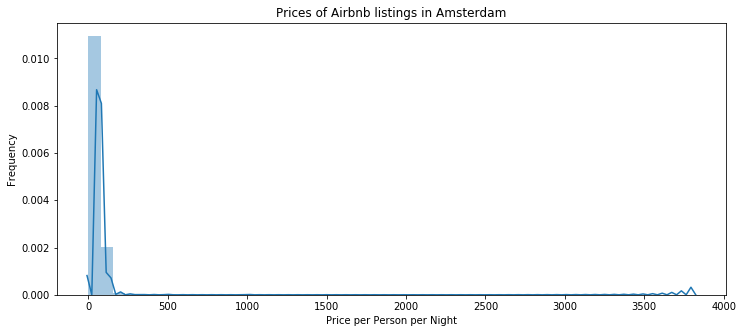

In [67]:
#Distribution of prices
plt.rcParams['figure.figsize'] = [12, 5]
sns.distplot(listings['price_pp']);
plt.xlabel('Price per Person per Night');
plt.ylabel('Frequency');
plt.title('Prices of Airbnb listings in Amsterdam');

### b) Remove outliers
As part of data preparation, I also remove price outliers using Tukey's rule. 

In [68]:
#Remove outliers using Tukey rule
IQR = listings['price_pp'].quantile(0.75) - listings['price_pp'].quantile(0.25)
lower_bound = listings['price_pp'].quantile(0.25) - 3*IQR
upper_bound = listings['price_pp'].quantile(0.75) + 3*IQR
lower_bound, upper_bound

(-40.0, 152.5)

In [69]:
#Override lower bound with a positive number 
lower_bound = 5
listings = listings[(listings['price_pp']>lower_bound) & (listings['price_pp']<upper_bound)]

In [70]:
listings.shape

(20114, 107)

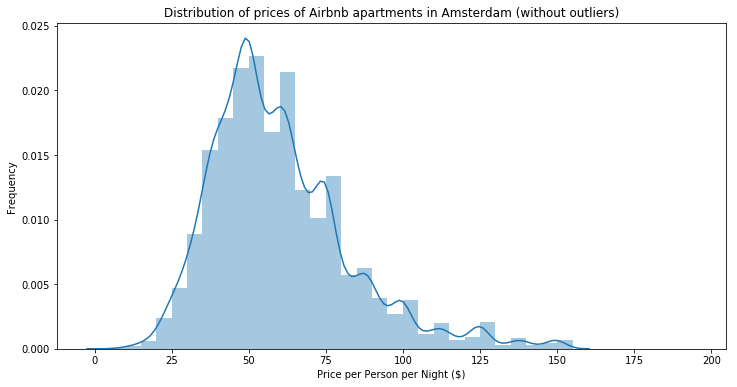

In [71]:
#Distribution of prices after removing outliers
plt.rcParams['figure.figsize'] = [12, 6]
#plt.rc('axes', labelsize = 14) 
#plt.rc('font', size=14)   
sns.distplot(listings['price_pp'][listings["room_type"]=='Entire home/apt'],bins = np.arange(0,200,5));
plt.xlabel('Price per Person per Night ($)');
plt.ylabel('Frequency');
plt.title('Distribution of prices of Airbnb apartments in Amsterdam (without outliers)');
#plt.savefig('Price Distribution')

In [72]:
listings['price_pp'].describe()

count    20114.000000
mean        57.875130
std         22.620987
min          6.625000
25%         42.500000
50%         53.500000
75%         70.000000
max        151.000000
Name: price_pp, dtype: float64

### c) Fill missing values
For the text analysis of Airbnb titles I need to make sure there are no missing values in the 'name' column. There are only a few such cases (34 in a dataset of more than 20k entries), so I can simply replace nans with a string 'No name'.

One part of the analysis also requires text processing of past guest reviews. For this reason, I also filled the missing values in the reviews dataset. The number of missing comments is negligible (195 in a dataset of almost 500k entries), so I can simply replace nans with a string 'No comment'.

In [73]:
#Fill the missing names (Airbnb title) in the listings dataset
listings['name'].fillna('No Name', inplace = True)

In [74]:
#Fill in the missing comments in the reviews dataset
reviews['comments'].fillna('No Comment', inplace = True)

### *d) Listing type
Most of the analyses are performed using only listings labelled as “entire home or apartment“ which represent roughly 80% of the entries in the listings data-set. Private rooms constitute the other 20%, but in my view cannot be put in the same basket. I made the filtering a part of every function used to carry out the respective analyses, so it is always transparent what exact subset of the original listings dataset has been used.

# 4. Data Modeling & 5. Results Evaluation
The analysis can be split in three different parts. Each part answers a specific question (or set of questions) posed in Section 1 above. Rather than first presenting all the analyses and only then commenting on the results, I add a section with results evaluation after each part of the analysis/data modeling.

## a) Calculate average price in each neighborhood

### Data Modeling

In the following I analyze listings in different Amsterdam neighborhoods and most importantly calculate the average price in each of them. The simple analysis is repeated on different subsets of the original dataset, therefore I implement the entire process in a function.

In [75]:
def price_neighborhood(df, filters = None):
    """" Calculates and visualizes the average price per person per night in each neighborhood. 
    Filters can be applied so the analysis can be repeated on different subsets of the original dataframe.
    
    Parameters
    ----------
    df : DataFrame, detailed data of Airbnb listings including their price per person per night
    filters: dict, column (str) and values (list) pairs used to filter the dataset 
    
    Returns
    -------
    avg_prices_df : DataFrame, average price per person per night in each neighborhood
    """
    
    #Empty Filter
    bools = [True]*df.shape[0]
    
    #Combine all the filters
    if filters:
        for column, value in filters.items():
            additional_filter = (df[column].isin(value))
            bools = bools & additional_filter

    #Apply the filters
    df_filtered = df[bools]
        
    #Calculate average prices in different neighborhoods
    avg_prices = df_filtered.groupby(['neighbourhood_cleansed'])['price_pp'].mean().sort_values(ascending = False)
    
    #Store them in a dataframe
    avg_prices_df = pd.DataFrame(avg_prices).reset_index()

    #Visualize the results
    colors = sns.color_palette('pastel')
    sns.barplot(y = 'neighbourhood_cleansed', x = 'price_pp', data = df_filtered, 
                order = avg_prices.index, orient='h', color= colors[3], zorder= 2)
    plt.xlabel('Average Price per Person per Night ($)')
    plt.ylabel('')
    plt.title('Average Prices in Amsterdam Neighborhoods')
    plt.subplots_adjust(left=0.35, right=0.9, top=0.95, bottom=0.07)
    plt.grid(axis = 'x', linestyle = '--', zorder=0)

    return avg_prices_df

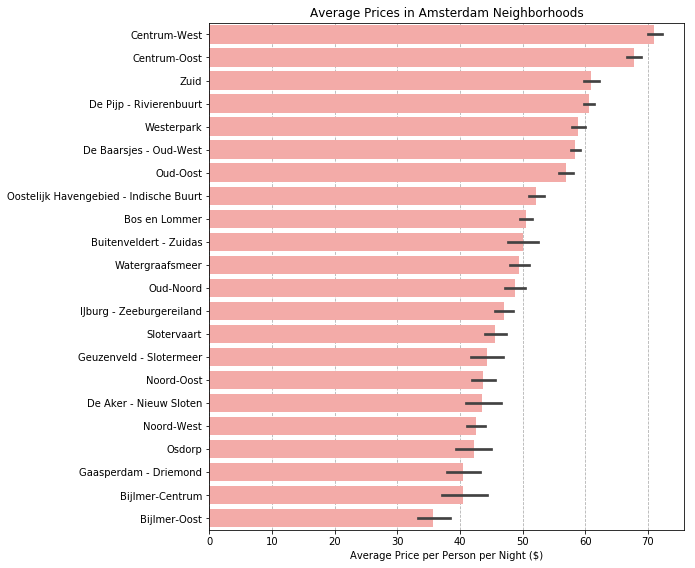

In [76]:
#Average prices for different neighborhoods, all listings
plt.rcParams['figure.figsize'] = [12, 8]
all_avg = price_neighborhood(listings);
#plt.savefig('Neighbourhoods')

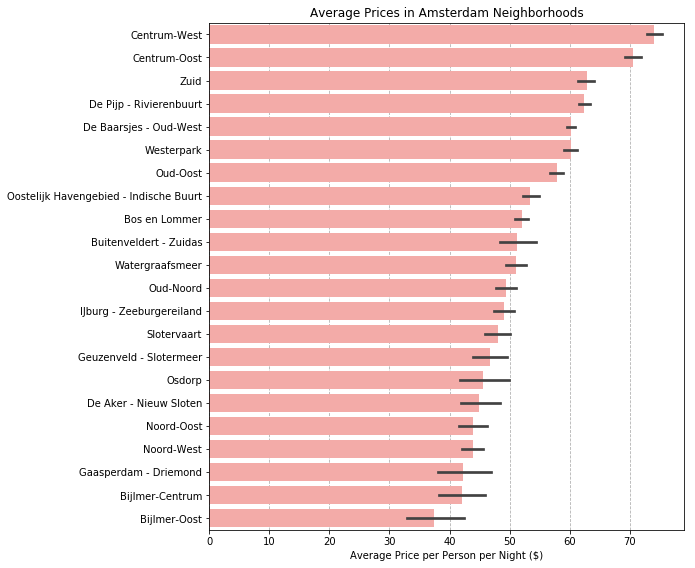

In [77]:
#Average prices for different neighborhoods, entire home/apartment listings only
#plt.rc('axes', labelsize = 13) 
#plt.rc('font', size = 13)   
homeapt_avg = price_neighborhood(listings, {'room_type': ['Entire home/apt']});
#plt.savefig('Neighbourhoods')

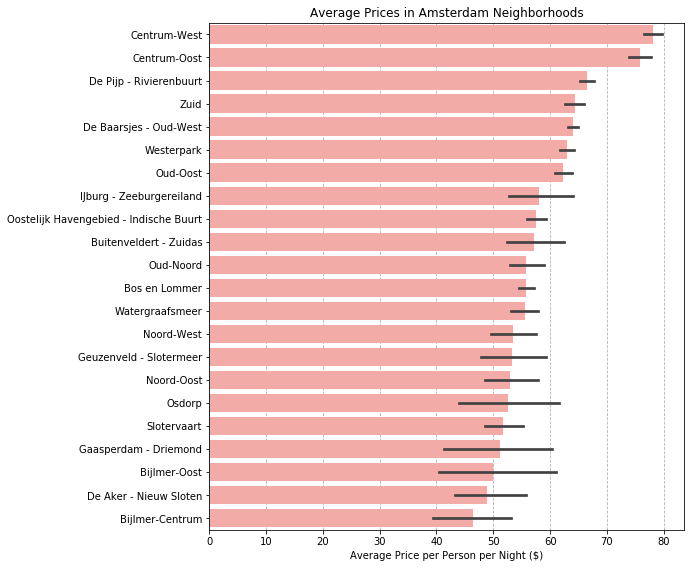

In [78]:
#Average prices for different neighborhoods, entire 2-person home/apartment listings only
homeapt2_avg = price_neighborhood(listings, {'room_type': ['Entire home/apt'], 'accommodates':[2]});

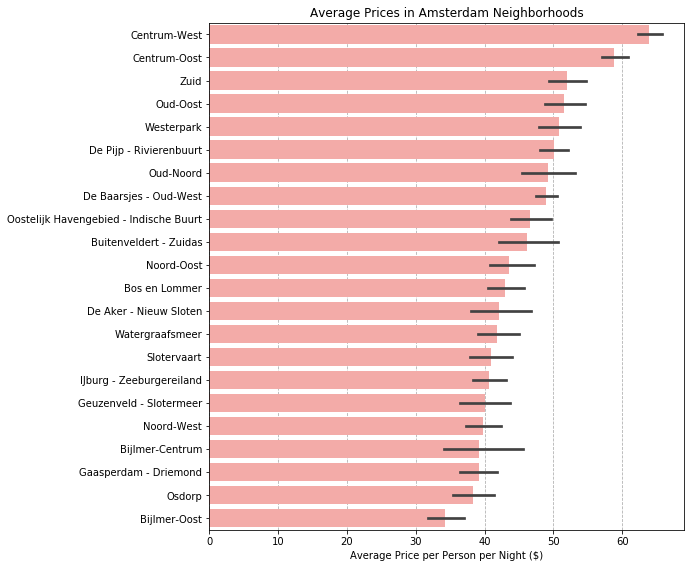

In [79]:
#Average prices for different neighborhoods, private rooms only
private_avg = price_neighborhood(listings, {'room_type': ['Private room']});

In [80]:
#Compare entire home prices and private room prices
compare = private_avg.merge(homeapt_avg, on = 'neighbourhood_cleansed')
compare['price_pp_x'] - compare['price_pp_y']

0    -10.162706
1    -11.711122
2    -10.760360
3     -6.339304
4     -9.362142
5    -12.423179
6     -0.181917
7    -11.279885
8     -6.843869
9     -5.036201
10    -0.373586
11    -9.010781
12    -2.828850
13    -9.184533
14    -7.109256
15    -8.360145
16    -6.658018
17    -4.066868
18    -2.812931
19    -3.046458
20    -7.307313
21    -3.059392
dtype: float64

In [81]:
#Correlation between prices of entire homes and private room prices
compare.corr()

,price_pp_x,price_pp_y
price_pp_x,1.000000,0.946059
price_pp_y,0.946059,1.000000


### Results Evaluation

**Entire homes/apartments only:**  As expected, the most expensive areas are the central ones, e.g. Centrum West and Oost (both more than 70 dollars per person per night), followed by the neighborhoods surrounding them, e.g. Oud-Zuid, De Pijp, De Baarsjes, Westerpark, Oud-Oost (all around 60 dollars). The Oud-Noord seems quite central when looking at the map, but is located north of the body of water called IJ, which seems to keep the mass tourism away (priced just below 50 dollars). The most affordable Airbnb apartments can be found in the Bijlmer areas located in the eastern part of the city, where the rent will cost roughly 40 dollars on average (per person per night).

**Private rooms only:** In almost all neighborhoods, private rooms are around 10 dollars cheaper than entire apartments, however, the prices between two types or listings are obviously strongly positively correlated (0.95).

## b)  Compare the percentage of guests reviews with positive comments about the location

### Data Modeling
It is common that guest reviews posted on Airbnb include statements regarding apartment’s location. I thought it would be interesting to analyze, for each neighborhood, what percentage of reviews (of respective listings) include positive comments about its location, and if such statistics are in line with the price differences presented above.

I use text processing techniques to identify reviews with such positive comments, and then obtain, through mapping (guest reviews from the `reviews` dataset are mapped to the corresponding listings in the `listings` dataset) and aggregation (from individual listings to neighborhoods), the percentage of positive location reviews in each neighborhood.

In this way I can analyze whether the users' opinions about the location are in line with the location-driven price differences, and potentially identify districts that seem under/over-priced given their location.

In [82]:
def positive_sentiment(text):
    """" Splits the input text into sentences, and determines whether there exists
    a sentence that includes a positive comment about the property location.
    
    Parameters
    ----------
    text : str, analyzed user review
    
    Returns
    -------
    positive_flag: boolean, indicates whether the review includes a positive comment about the location
    """
    
    #Split the input text into sentences
    sentences = sent_tokenize(text)
    
    #Clean the sentences and keep the ones that include the word 'location'
    sentences_clean = [re.sub(r'[^a-zA-Z0-9]', ' ', sent.lower()).strip() for sent in sentences 
                       if 'location' in sent.lower()]
    
    #In case there are more sentences describing location, merge them together as one long sentence
    one_string = " ".join(sentences_clean)
    
    #Tokenize the sentence into words
    location_words = set(word_tokenize(one_string))
    
    #Define words that represent positive sentiment
    positive_words = ['central', 'good', 'nice', 'best', 'great', 'perfect', 'excellent', 
            'superb', 'amazing', 'awesome', 'incredible', 'wonderful']
    
    #Determine whether the (merged) sentence about the location includes any of the positive words and 
    #excludes the word 'not' 
    if ((len(location_words.intersection(positive_words))  >=1) & ('not' not in location_words)):
        positive_flag = True
    else: 
        positive_flag = False
    
    return positive_flag

In [83]:
positive_sentiment('The location was just excellent.')

True

In [84]:
positive_sentiment('The apartments is nice. But the location is not so great')

False

In [85]:
#Create a new column that identifies positive location reviews
reviews['positive_location_review'] = reviews['comments'].apply(positive_sentiment)

In [86]:
#Total umber of positive location reviews
reviews['positive_location_review'].sum()

99884

In [87]:
#Total relative number of positive location reviews
reviews['positive_location_review'].sum()/reviews.shape[0]

0.21124002317879395

In [88]:
#Count the number of reviews per listing and number of positive location reviews per listing
review_counts = reviews.groupby('listing_id')['positive_location_review'].count()
positive_review_counts = reviews.groupby('listing_id')['positive_location_review'].sum()

In [89]:
#Store the information into a dataframe
review_counts_df = pd.concat([review_counts, positive_review_counts],axis=1)
review_counts_df.columns = ['total_count','positive_count']
review_counts_df.index.name = 'id'

In [90]:
#Map the newly calculated information to the entries in the listings dataframe. Apply filters here too.
listings_data = listings[['id','neighbourhood_cleansed']]
additional_filter = (listings['room_type'] == 'Entire home/apt')
listings_data = listings_data[additional_filter]
merged_df = listings_data.merge(review_counts_df, on ='id')

In [91]:
merged_df.head()

,id,neighbourhood_cleansed,total_count,positive_count
0,25428,Centrum-West,3,2.0
1,31080,Zuid,32,4.0
2,38266,Centrum-West,199,57.0
3,41125,Centrum-West,85,29.0
4,43109,Centrum-West,690,31.0


In [92]:
merged_df.shape

(13943, 4)

In [93]:
#Calculate the total number of reviews per neighborhood and total number of positive location revies per neighborhood
review_counts_nh = merged_df.iloc[:,1:].groupby('neighbourhood_cleansed').sum()
review_counts_nh['positive_location_ratio'] = 100*review_counts_nh['positive_count'] / review_counts_nh['total_count']

In [94]:
#Order the neighborhoods with respect to the ratio of reviews that positively comment on the location
review_counts_nh.sort_values('positive_location_ratio', ascending = False)

,total_count,positive_count,positive_location_ratio
neighbourhood_cleansed,,,
Centrum-West,37350,12890.0,34.511379
Centrum-Oost,27792,8493.0,30.559154
De Pijp - Rivierenbuurt,29673,7183.0,24.207192
De Baarsjes - Oud-West,42120,9158.0,21.742640
Zuid,16930,3473.0,20.513881
Westerpark,20337,3903.0,19.191621
Oud-Oost,14669,2557.0,17.431318
Oostelijk Havengebied - Indische Buurt,10434,1303.0,12.488020
Oud-Noord,7351,828.0,11.263774


In [95]:
#Combine the dataset with percentage of positive reviews with the dataset that shows average prices
final_results = review_counts_nh.merge(homeapt_avg, on ='neighbourhood_cleansed').sort_values('positive_location_ratio', 
                                                                                          ascending = False)
final_results

,neighbourhood_cleansed,total_count,positive_count,positive_location_ratio,price_pp
5,Centrum-West,37350,12890.0,34.511379,74.090627
4,Centrum-Oost,27792,8493.0,30.559154,70.566131
8,De Pijp - Rivierenbuurt,29673,7183.0,24.207192,62.433564
7,De Baarsjes - Oud-West,42120,9158.0,21.742640,60.243271
21,Zuid,16930,3473.0,20.513881,62.788498
20,Westerpark,20337,3903.0,19.191621,60.128220
17,Oud-Oost,14669,2557.0,17.431318,57.834228
14,Oostelijk Havengebied - Indische Buurt,10434,1303.0,12.488020,53.463748
16,Oud-Noord,7351,828.0,11.263774,49.327339
19,Watergraafsmeer,6048,655.0,10.830026,51.035228


In [96]:
#Calculate the correlation coefficient between the average prices and the relative number of positive location reviews
print(final_results[['positive_location_ratio', 'price_pp']].corr())
print(final_results[['positive_location_ratio', 'price_pp']].corr('kendall'))

                         positive_location_ratio  price_pp
positive_location_ratio                 1.000000  0.971428
price_pp                                0.971428  1.000000
                         positive_location_ratio  price_pp
positive_location_ratio                 1.000000  0.844156
price_pp                                0.844156  1.000000


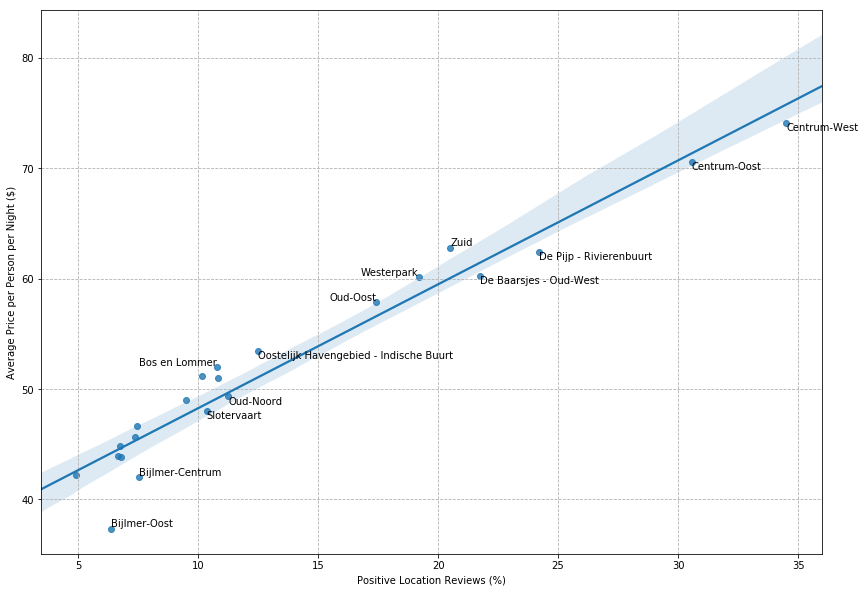

In [97]:
#Show the relationship with a scatter plot
plt.rcParams['figure.figsize'] = [14, 10]
#plt.rc('axes', labelsize = 14) 
#plt.rc('font', size=16)   
sns.regplot('positive_location_ratio', 'price_pp', data = final_results);
plt.xlabel('Positive Location Reviews (%)');
plt.ylabel('Average Price per Person per Night ($)');
plt.grid( linestyle = '--')

add_text = [0, 1, 2, 4, 5, 7, 8, 14, 16, 17, 18, 20, 21]
horizontal = ['left','left','right','left','left','left','left','left','left','right','left','right','left']
vertical = ['bottom','bottom','bottom','top','top','top','top','top','top','bottom','top','bottom','bottom']
for i in range(len(add_text)):
    plt.text(final_results['positive_location_ratio'][add_text[i]],
             final_results['price_pp'][add_text[i]], 
             final_results['neighbourhood_cleansed'][add_text[i]],
             horizontalalignment = horizontal[i],
             verticalalignment = vertical[i])
#plt.savefig('Location Reviews')

### Results Evaluation

It is natural to expect that in the more central and therefore more expensive areas guests will more likely express their satisfaction with the apartment’s location. As can be seen from the plot, the two measured variables, i.e. the average price per person per night and the percentage of positive location reviews, are in fact very strongly positively correlated. There are essentially no neighborhoods that would stand out for being significantly over or under priced given their location.

This simple analysis supports two generally accepted truths: a) location is everything (at least when measuring average prices of different neighborhoods), and b) market prices are generally right.

Even though the deviations from the strong linear relationship are not large, some comparisons between neighborhoods can still be made. For example, it seems that, in relative terms, De Pijp area gets significantly more positive location reviews than a slightly more expensive Zuid neighborhood. Similar observation can be made if comparing Oud West and Westerpark. Also, Bos en Lommer neighborhood is relatively expensive compared to areas such as Oud-Noord or Slotervaart, despite the similar ratio of positive location reviews.

## c) Identify value-adding features from Airbnb listings' titles

### Data Modeling
Location is one of the main factors impacting Airbnb prices, but on the level of individual listings there are obviously several other differentiating aspects. In the last part of my analysis I aim to identify features that add value to Airbnb apartments, by analyzing the information contained in listings’ textual descriptions.

For each specific feature of interest I perform a word search through the Airbnb listings’ titles and split the input data-set into two subsets, separating listings with and without specific feature advertised. I then compare the distribution of prices between the two data-sets and construct a confidence interval for the difference in means. In this way I can identify features that have a significant impact on the prices.

Specifically, I try to answer questions such as: how much extra on average one needs to pay if the flat is advertised as luxurious, or spacious, or modern, etc., or how large is the premium for having a garden, or very specific to Amsterdam, how much more expensive is it to stay next to a canal, or on it, in a houseboat.

In [98]:
def tokenize(text):
    """ Normalize input text, tokenize it into words, remove stopwords and return lemmatized tokens
    
    Parameters
    ----------
    text : str, input text to be tokenized
    
    Returns
    -------
    lemmed: list, lemmatized tokens
    """
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    tokens = word_tokenize(text)
    
    tokens_subset = [v.strip() for v in tokens if v.strip() not in set(stopwords.words('english'))]
    
    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(w) for w in tokens_subset]
    
    return lemmed

In [99]:
#Find the most common tokens in listings' names (titles)

#Obtain matrix of token counts
count = CountVectorizer(tokenizer = tokenize)
names_wordcount = count.fit_transform(listings['name'])
#Aggregate to obtain total token count
wordcount_raw = names_wordcount.sum(axis=0)
#Map the total token counts to tokens 
wordcount_mapped = [(word, wordcount_raw[0, i]) for word, i in count.vocabulary_.items()]
#Store the token-count pairs into a dataframe
wordcount_df = pd.DataFrame(wordcount_mapped, columns =['word','count']).sort_values(by='count', ascending=False)
wordcount_df[:50]

,word,count
30,apartment,7930
35,amsterdam,4758
119,spacious,2377
14,city,2143
3,room,1965
10,centre,1951
79,house,1744
17,near,1699
36,center,1608
1,garden,1564


In [100]:
def mean_difference(df, keyword, text_column = 'name', filters = None, plot_text = "", confidence_level = 90):
    """ Split the input dataset into two subsets, separating listings that have a specific keyword
    in the name or description and the ones that do not. Compare the distribution of prices between the
    two datasets and construct a confidence interval for the difference in means.
    
    Parameters
    ----------
    df : DataFrame, detailed data of Airbnb listings including their price per person per night
    keyword : str, specific keyword used to separate the dataset
    text_column : str, analyzed column with textual descriptions of properties, 'name' or 'description'
    filters : dict, column(str) - value(list) pairs used to filter the original dataset
    plot_text : str, text used in the visualization
    confidence_level : int, confidence level used to construct confidence intervals
    
    Returns
    -------
    None
    
    """
    #Empty filter
    bools = [True]*df.shape[0]
    
    #Apply filters to obtain the desired subset
    if filters:
        for column, value in filters.items():
            additional_filter = (df[column].isin(value))
            bools = bools & additional_filter
    df = df[bools]
    
    # Check each name if it includes the input keyword 
    keyword_flag = df[text_column].apply(lambda x: 1 if keyword in x.lower() else 0)
    
    # Split the input dataframe into two sets - one with the keyword in the name and one without
    prices_keyword = df['price_pp'][keyword_flag == 1]
    prices_other = df['price_pp'][keyword_flag == 0]
    
    #Plot the distribution
    bins = np.arange(0,200,5)
    sns.distplot(prices_keyword, bins, kde = True, norm_hist = True)
    sns.distplot(prices_other, bins, kde = True, norm_hist = True, color = 'red')
    plt.title(f'Keyword: "{keyword}"')
    plt.xlabel('Price per Person per Night ($)')
    
    #Text in the legend
    if plot_text == "":
        plot_text = keyword
    
    plt.legend([f'Listings advertised as {plot_text}','Other'])
    
    #Calculate the confidence interval for the mean difference
    m1 = prices_keyword.mean()
    m2 = prices_other.mean()
    
    s1 = prices_keyword.std()
    s2 = prices_other.std()
    
    n1 = len(prices_keyword)
    n2 = len(prices_other)
    
    se = np.sqrt((s1 ** 2)/n1 + (s2 ** 2)/n2)
    
    #Sample mean difference
    stat = m1-m2
    
    #Inverse CDF
    p = 1 - (1 - confidence_level/100)/2
    critical = norm.ppf(p)
    
    #Confidence interval
    #lower_bound = stat - se * critical
    #upper_bound = stat + se * critical
    
    output_str = f'Difference in means: {stat:.2f} (+/- {se * critical:.2f})'
    
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    plt.text(-5, 0.001, output_str , fontsize=18,
        verticalalignment='bottom', bbox = props)

    
    #print(f'Average price difference : {stat:.2f} +/- {se * critical:.2f}')

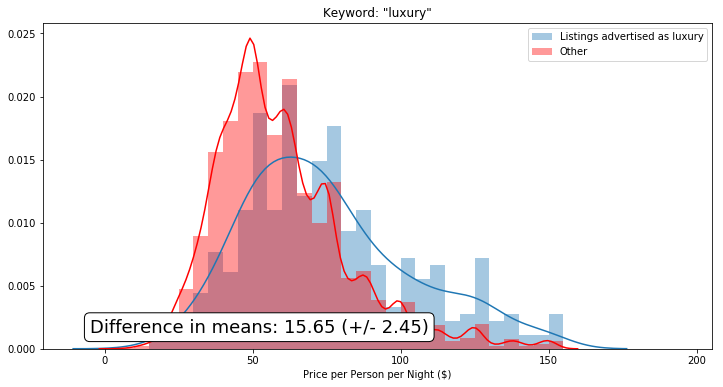

In [101]:
plt.rcParams['figure.figsize'] = [12, 6]
mean_difference(listings, 'luxury', filters = {'room_type':['Entire home/apt']})
#plt.savefig('luxury')

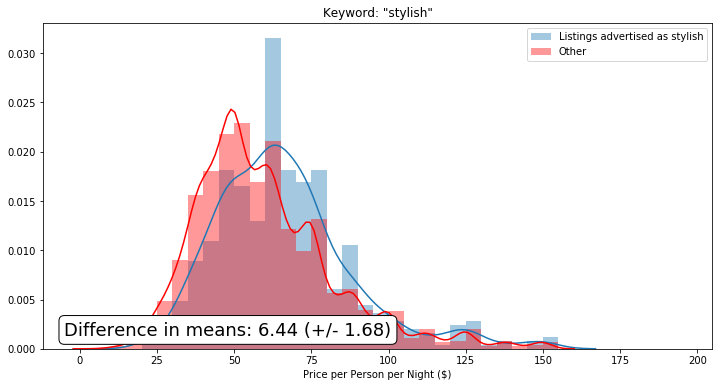

In [102]:
mean_difference(listings, 'stylish',  filters = {'room_type':['Entire home/apt']})
#plt.savefig('stylish')

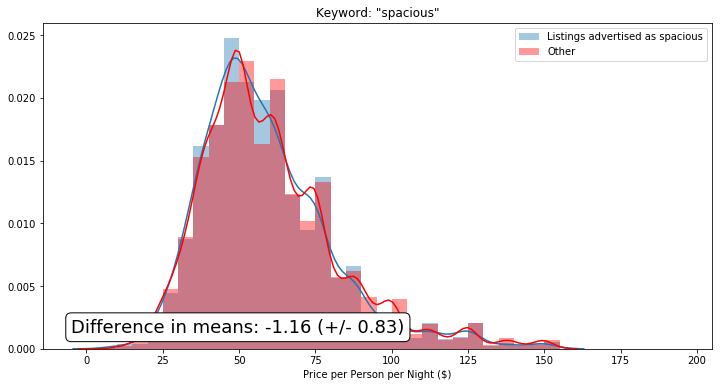

In [103]:
mean_difference(listings, 'spacious',  filters = {'room_type':['Entire home/apt']})
#plt.savefig('spacious')

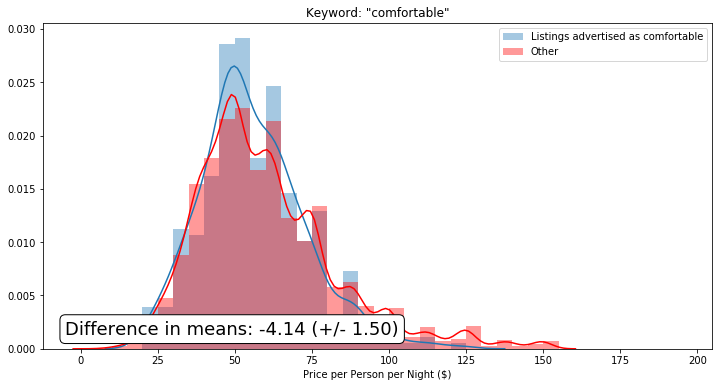

In [104]:
mean_difference(listings, 'comfortable', filters = {'room_type':['Entire home/apt']})
#plt.savefig('comfortable')

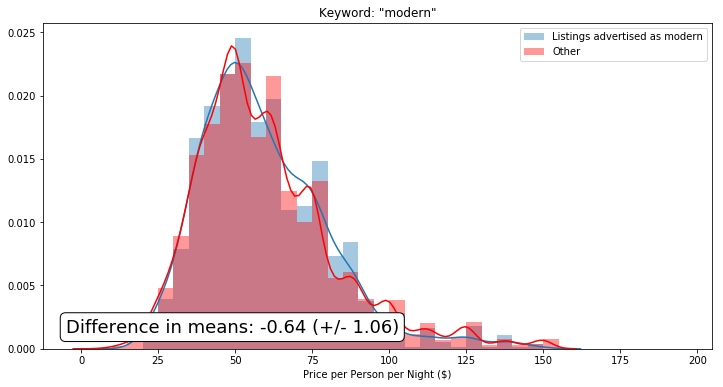

In [105]:
mean_difference(listings, 'modern', filters = {'room_type':['Entire home/apt']})
#plt.savefig('modern')

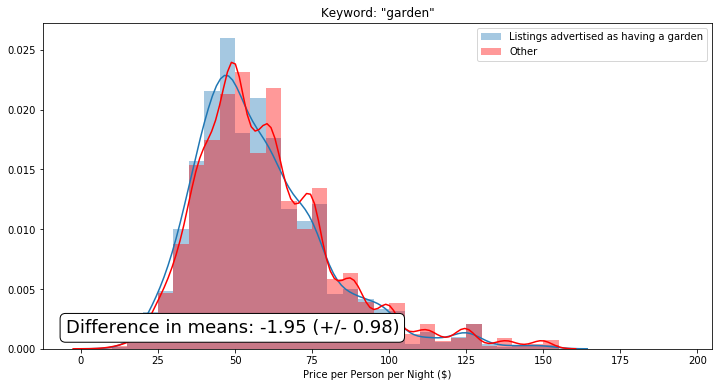

In [106]:
mean_difference(listings, 'garden', plot_text = 'having a garden', filters = {'room_type':['Entire home/apt']})
#plt.savefig('garden')

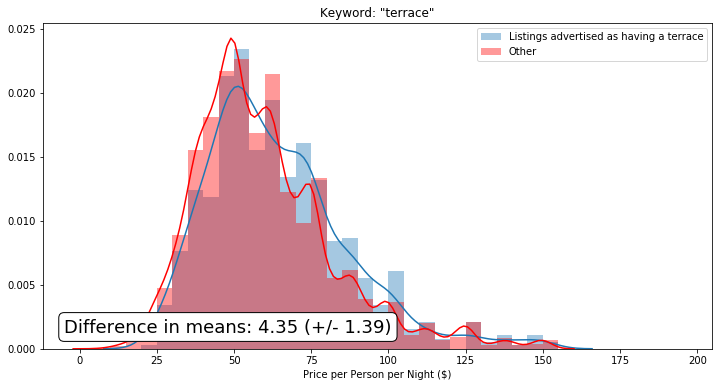

In [107]:
mean_difference(listings, 'terrace', plot_text = 'having a terrace', filters = {'room_type':['Entire home/apt']})
#plt.savefig('terrace')

**Note:** All the above analyses have been performed using listings (entire homes or apartments) in all neighborhoods. For some keywords, however, I need to control for the location variable, since the distributions of apartments with/without specific feature vary drastically among different neighborhoods. For this reason, the last two plots have been generated using only listings in the two central Amsterdam neighborhoods, Central West and Oost.

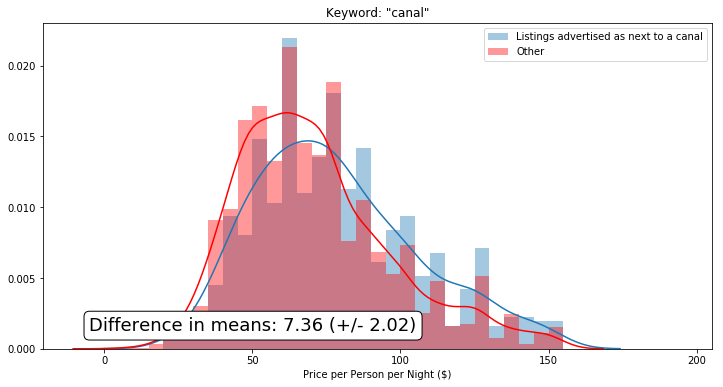

In [108]:
mean_difference(listings, 'canal', filters = {'neighbourhood_cleansed' : ['Centrum-West', 'Centrum-Oost'],
                                              'room_type':['Entire home/apt']}, plot_text = 'next to a canal')
#plt.savefig('canal')

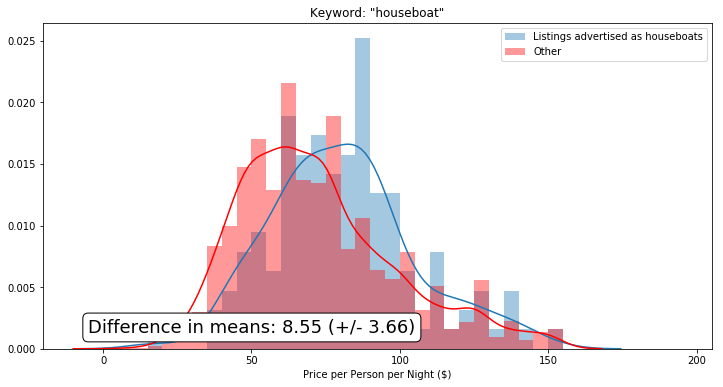

In [109]:
mean_difference(listings, 'houseboat', filters = {'neighbourhood_cleansed' : ['Centrum-West', 'Centrum-Oost'],
                                                 'room_type':['Entire home/apt']}, plot_text = 'houseboats')
#plt.savefig('houseboat')

### Results Evaluation
Apartments advertised as **luxury** are on average 15.65 dollars more expensive (per person per night) than other Airbnb apartments in Amsterdam.

Style (keyword **stylish**) seems important too, as it increases the average price by 6.44 dollars. On the other hand, the apartments advertised as **spacious** do not come with significantly different prices.

Often the Airbnb titles also mention specific amenities that can be seen as value added. Listings with a **terrace** are indeed 4.35 dollars more expensive on average, whereas homes which specifically advertise their **garden** are typically even slightly more affordable.

Staying in one of the central districts is expensive, but even more so if renting a place just next to a **canal**, as this will (on average) costs an additional 7.36 dollars per person per night.

Similarly, if one wants to spend time in Amsterdam floating on a **houseboat**, it will cost an additional 8.55 dollars per person per night.
